In [148]:
print(torch.__version__)

0.4.0a0+da6c3c9


# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]


(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

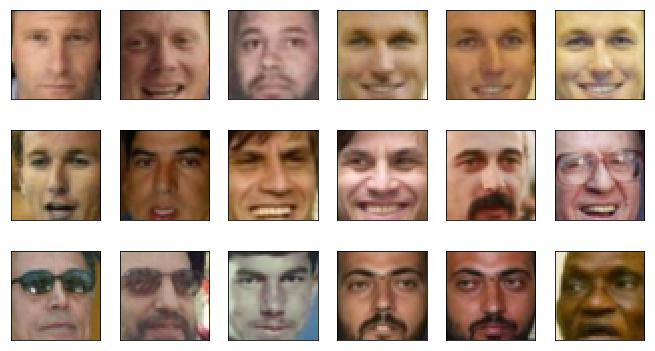

In [6]:
plot_gallery(X_train, image_h, image_w)

In [7]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [8]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.lin1 = nn.Linear(in_features=6075, out_features=768)
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.constant_(self.lin1.bias, 0.0)
        self.lin12 = nn.Linear(in_features=768, out_features=256)
        nn.init.xavier_uniform_(self.lin12.weight)
        nn.init.constant_(self.lin12.bias, 0.0)
        self.lin2 = nn.Linear(in_features=256, out_features=dimZ)
        nn.init.xavier_uniform_(self.lin2.weight)
        nn.init.constant_(self.lin1.bias, 0.0)
        self.lin3 = nn.Linear(in_features=dimZ, out_features=512)
        nn.init.xavier_uniform_(self.lin3.weight)
        nn.init.constant_(self.lin1.bias, 0.0)
        self.lin4 = nn.Linear(in_features=512, out_features=6075)
        nn.init.xavier_uniform_(self.lin4.weight)
        nn.init.constant_(self.lin1.bias, 0.0)
        
    def encode(self, x):
        return self.lin2(self.relu(self.lin12(self.relu(self.lin1(x)))))
    
    def decode(self, latent_code):
        return self.sigm(self.lin4(self.relu(self.lin3(latent_code))))
        
    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)        
        return reconstruction, latent_code

In [17]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

train_loss_ae = []
val_loss_ae = []
from torch.optim.lr_scheduler import StepLR
sched = StepLR(optimizer, step_size=40, gamma = 0.1)

In [18]:
import time
num_epochs = 85 
batch_size = 100

try:
    for epoch in range(num_epochs):
        start_time = time.time()
        sched.step()
        autoencoder.train(True)
        for (X_batch, y_batch) in train_loader:
            rec, _ = autoencoder(X_batch)
            loss = criterion(rec, X_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_ae.append(loss.data.numpy())
        autoencoder.train(False)
        t = 0
        for (X_batch, y_batch) in val_loader:
            rec, _ = autoencoder(X_batch)
            loss = criterion(rec, X_batch)
            val_loss_ae.append(loss.data.numpy())
            t += 1
            if t > 99:
                break
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss_ae[-len(X_train) // batch_size :])))
        print("  validation loss (in-iteration): \t{:.6f}".format(
            np.mean(val_loss_ae[-100 :])))

except KeyboardInterrupt:
    pass

Epoch 1 of 85 took 158.586s
  training loss (in-iteration): 	0.020534
  validation loss (in-iteration): 	0.014951
Epoch 2 of 85 took 115.136s
  training loss (in-iteration): 	0.013578
  validation loss (in-iteration): 	0.012479
Epoch 3 of 85 took 115.143s
  training loss (in-iteration): 	0.011182
  validation loss (in-iteration): 	0.009668
Epoch 4 of 85 took 115.204s
  training loss (in-iteration): 	0.009157
  validation loss (in-iteration): 	0.007942
Epoch 5 of 85 took 115.855s
  training loss (in-iteration): 	0.007802
  validation loss (in-iteration): 	0.007133
Epoch 6 of 85 took 115.269s
  training loss (in-iteration): 	0.007040
  validation loss (in-iteration): 	0.006775
Epoch 7 of 85 took 123.873s
  training loss (in-iteration): 	0.006497
  validation loss (in-iteration): 	0.006055
Epoch 8 of 85 took 136.967s
  training loss (in-iteration): 	0.006067
  validation loss (in-iteration): 	0.005784
Epoch 9 of 85 took 141.668s
  training loss (in-iteration): 	0.005891
  validation loss 

Epoch 73 of 85 took 137.261s
  training loss (in-iteration): 	0.003228
  validation loss (in-iteration): 	0.003615
Epoch 74 of 85 took 137.105s
  training loss (in-iteration): 	0.003224
  validation loss (in-iteration): 	0.003608
Epoch 75 of 85 took 136.667s
  training loss (in-iteration): 	0.003221
  validation loss (in-iteration): 	0.003614
Epoch 76 of 85 took 136.844s
  training loss (in-iteration): 	0.003218
  validation loss (in-iteration): 	0.003607
Epoch 77 of 85 took 137.033s
  training loss (in-iteration): 	0.003214
  validation loss (in-iteration): 	0.003612
Epoch 78 of 85 took 136.887s
  training loss (in-iteration): 	0.003213
  validation loss (in-iteration): 	0.003597
Epoch 79 of 85 took 137.017s
  training loss (in-iteration): 	0.003208
  validation loss (in-iteration): 	0.003600
Epoch 80 of 85 took 136.193s
  training loss (in-iteration): 	0.003204
  validation loss (in-iteration): 	0.003598
Epoch 81 of 85 took 136.937s
  training loss (in-iteration): 	0.003177
  validat

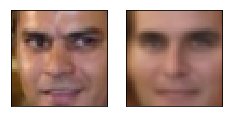

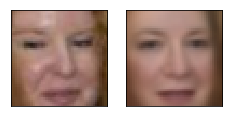

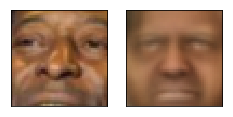

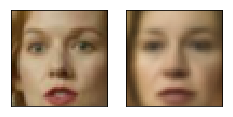

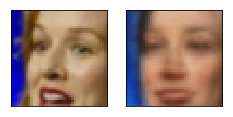

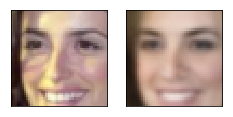

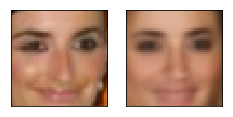

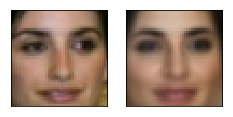

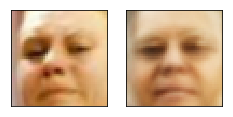

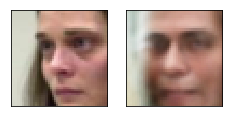

In [19]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0])
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

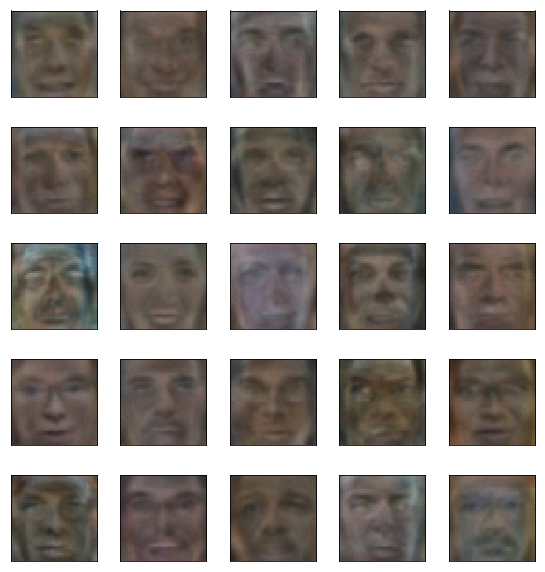

In [146]:
z = np.random.randn(25, dimZ) * 0.3
t = Variable(torch.from_numpy(z).float())
output = autoencoder.decode(t)
plot_gallery(output.data.numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

Думаю, если сеть будет достаточно глубока и хорошо обучена, то генерация всех лиц из нормального распределения возможна.

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [79]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here
#https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.bnorm1 = nn.BatchNorm1d(384)
        self.bnorm2 = nn.BatchNorm1d(384)
        self.lin1 = nn.Linear(6075, 384)
        self.lin21 = nn.Linear(384, dimZ)
        self.lin22 = nn.Linear(384, dimZ)
        self.lin3 = nn.Linear(dimZ, 384)
        self.lin41 = nn.Linear(384, 6075)
        self.lin42 = nn.Linear(384, 6075)
        
    def encode(self, x):
        temp = self.relu(self.bnorm1(self.lin1(x)))
        return self.lin21(temp), self.lin22(temp)
    
    def decode(self, latent_vector):
        temp = self.relu(self.bnorm2(self.lin3(latent_vector)))
        return self.lin41(temp), self.lin42(temp)
        
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add(mu)
        else:
            return mu

    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        gaussian = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(gaussian)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

Потому что если брать $\sigma$, то при небольшом изменении выхода, близкого к нулю, логарифм, а, следовательно, и функция потерь, может значительно измениться, что не очень хорошо. Вдобавок в этом случае функция потерь считается дольше, т.к. появляется лишнее деление / возведение в квадрат.

In [80]:
import math
def KL_divergence(mu, logsigma):
    return -0.5 * (1 + 2 * logsigma - mu * mu - torch.exp(2 * logsigma)).sum(dim=1).mean()

def log_likelihood(x, mu, logsigma):
    subs = x - mu
    return -1. * (subs * subs / 2 / torch.exp(2 * logsigma) + \
             torch.log(torch.exp(logsigma) * np.sqrt(2 * math.pi))).sum(dim=1).mean()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

In [81]:
vae = VAE()

opt = optim.Adam(vae.parameters())

train_loss = []
val_loss = []
from torch.optim.lr_scheduler import StepLR
sch = StepLR(opt, step_size=40, gamma = 0.1)

In [82]:
from IPython import display
import time
num_epochs = 85
batch_size = 100

try:
    for epoch in range(num_epochs):
        start_time = time.time()
        sch.step()
        vae.train(True)
        for (X_batch, y_batch) in train_loader:
            rec_mu, rec_ls, l_mu, l_ls = vae(X_batch)
            loss = loss_vae(X_batch, rec_mu, rec_ls, l_mu, l_ls)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss.append(loss.data.numpy())
        vae.train(False)  
        t = 0
        for (X_batch, y_batch) in val_loader:
            rec_mu, rec_ls, l_mu, l_ls = vae(X_batch)
            loss = loss_vae(X_batch, rec_mu, rec_ls, l_mu, l_ls)
            val_loss.append(loss.data.numpy())
            t += 1
            if t > 99:
                break
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation loss (in-iteration): \t{:.6f}".format(
            np.mean(val_loss[-100:])))
    
except KeyboardInterrupt:
    pass

Epoch 1 of 85 took 145.559s
  training loss (in-iteration): 	-1396.619507
  validation loss (in-iteration): 	-1810.770142
Epoch 2 of 85 took 135.019s
  training loss (in-iteration): 	-4512.727539
  validation loss (in-iteration): 	-4272.001465
Epoch 3 of 85 took 132.601s
  training loss (in-iteration): 	-5641.383301
  validation loss (in-iteration): 	-5873.863281
Epoch 4 of 85 took 131.420s
  training loss (in-iteration): 	-6088.486816
  validation loss (in-iteration): 	-6086.816406
Epoch 5 of 85 took 130.534s
  training loss (in-iteration): 	-6600.195801
  validation loss (in-iteration): 	-5964.092285
Epoch 6 of 85 took 130.568s
  training loss (in-iteration): 	-6826.843262
  validation loss (in-iteration): 	-6486.417480
Epoch 7 of 85 took 131.047s
  training loss (in-iteration): 	-7092.985840
  validation loss (in-iteration): 	-6960.341309
Epoch 8 of 85 took 127.704s
  training loss (in-iteration): 	-7260.727051
  validation loss (in-iteration): 	-6068.259766
Epoch 9 of 85 took 125.2

Epoch 68 of 85 took 123.909s
  training loss (in-iteration): 	-9676.141602
  validation loss (in-iteration): 	-9504.814453
Epoch 69 of 85 took 123.825s
  training loss (in-iteration): 	-9653.710938
  validation loss (in-iteration): 	-9617.759766
Epoch 70 of 85 took 123.943s
  training loss (in-iteration): 	-9628.856445
  validation loss (in-iteration): 	-9604.352539
Epoch 71 of 85 took 123.471s
  training loss (in-iteration): 	-9675.612305
  validation loss (in-iteration): 	-9906.183594
Epoch 72 of 85 took 123.532s
  training loss (in-iteration): 	-9694.840820
  validation loss (in-iteration): 	-9895.242188
Epoch 73 of 85 took 124.034s
  training loss (in-iteration): 	-9718.279297
  validation loss (in-iteration): 	-9766.474609
Epoch 74 of 85 took 123.768s
  training loss (in-iteration): 	-9696.004883
  validation loss (in-iteration): 	-9767.684570
Epoch 75 of 85 took 123.703s
  training loss (in-iteration): 	-9703.067383
  validation loss (in-iteration): 	-9607.255859
Epoch 76 of 85 t

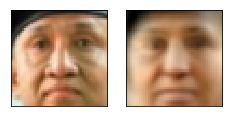

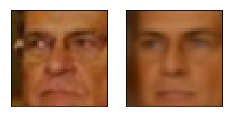

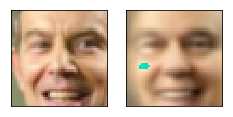

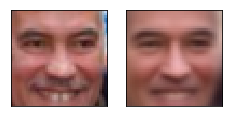

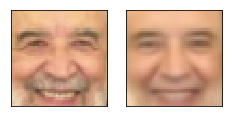

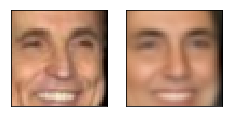

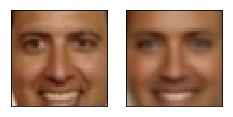

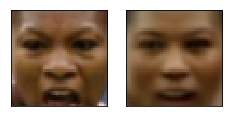

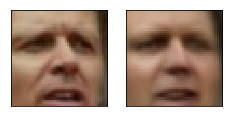

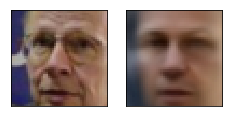

In [147]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0])
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), torch.relu(reconstruction_mu).data.numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

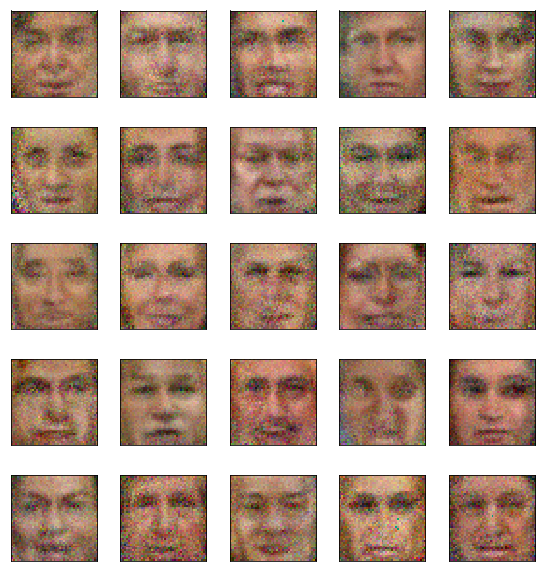

In [106]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
z = np.random.randn(25, dimZ) * .75
t = Variable(torch.from_numpy(z).float())
mu_rec, logsigma_rec = vae.decode(t)
sample = np.exp(logsigma_rec.data.numpy()) * np.random.randn(25, 6075) + mu_rec.data.numpy()
sample[sample < 0] = 0
plot_gallery(sample, image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

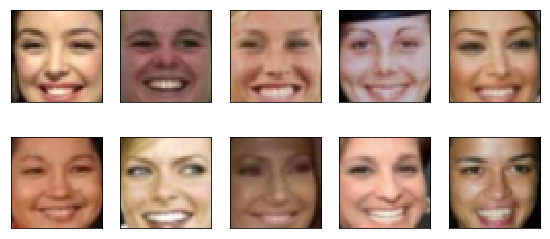

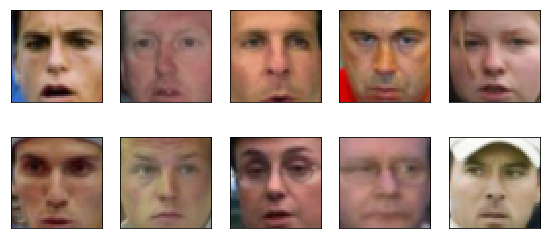

In [27]:
nsm_stat = np.partition(attrs['Smiling'].values[:10000], 9)[9]
sm_stat = np.partition(attrs['Smiling'].values[:10000], 10000-10)[10000-10]
sm_ind = np.where(attrs['Smiling'].values[:10000] >= sm_stat)
nsm_ind = np.where(attrs['Smiling'].values[:10000] <= nsm_stat)
plot_gallery(X_train[sm_ind], image_h, image_w, n_row=2, n_col=5)
plot_gallery(X_train[nsm_ind], image_h, image_w, n_row=2, n_col=5)

In [28]:
sm_latent_ae = autoencoder.encode(Variable(torch.from_numpy(X_train[sm_ind]))).mean(dim=0)
nsm_latent_ae = autoencoder.encode(Variable(torch.from_numpy(X_train[nsm_ind]))).mean(dim=0)
diff_ae = sm_latent_ae - nsm_latent_ae
print(diff_ae.size())

torch.Size([100])


In [92]:
sm_latent_mu, sm_latent_ls = vae.encode(Variable(torch.from_numpy(X_train[sm_ind])))
sm_latent_vae = vae.gaussian_sampler(sm_latent_mu, sm_latent_ls).mean(dim=0)
nsm_latent_mu, nsm_latent_ls = vae.encode(Variable(torch.from_numpy(X_train[nsm_ind])))
nsm_latent_vae = vae.gaussian_sampler(nsm_latent_mu, nsm_latent_ls).mean(dim=0)
diff_vae = sm_latent_vae - nsm_latent_vae
print(diff_vae.size())

torch.Size([100])


In [140]:
nsm_sample = Variable(torch.from_numpy(X_val[np.where(attrs['Smiling'].values[10000:] < -2.)][20]))

/home/andrejka/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


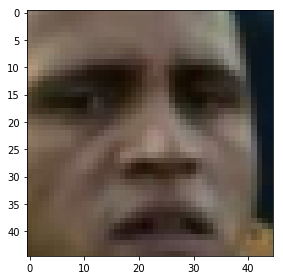

In [139]:
from skimage.io import imshow
imshow(X_val[np.where(attrs['Smiling'].values[10000:] < -2.)][20].reshape(45,45,3))

/home/andrejka/anaconda3/lib/python3.6/site-packages/torch/autograd/variable.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


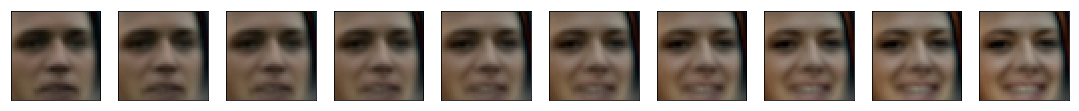

In [141]:
sample_latent_mu, sample_latent_ls = vae.encode(nsm_sample.resize(1,6075))
sample_latent_vae = vae.gaussian_sampler(sample_latent_mu, sample_latent_ls)
imgs = []
for i in range(10):
    img, _ = vae.decode(sample_latent_vae + ((i+1) / 10) * diff_vae)
    imgs.append(img.data.numpy())
plot_gallery(np.abs(imgs), image_h, image_w, n_row=1, n_col=10)

/home/andrejka/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


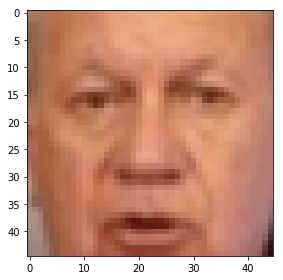

In [142]:
nsm_sample = Variable(torch.from_numpy(X_val[np.where(attrs['Smiling'].values[10000:] < -2.)][10]))
imshow(X_val[np.where(attrs['Smiling'].values[10000:] < -2.)][10].reshape(45,45,3))

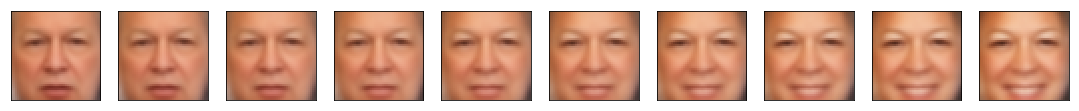

In [143]:
sample_latent_ae = autoencoder.encode(nsm_sample)
imgs = []
for i in range(10):
    imgs.append(autoencoder.decode(sample_latent_ae + ((i+1) / 10) * diff_ae).data.numpy())
plot_gallery(imgs, image_h, image_w, n_row=1, n_col=10)

<img src="linear.png" alt="linear">